# Clasificación Astronómicos


### Se importan las librerías necesarias generar el modelo


In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    mean_absolute_error, mean_squared_error, median_absolute_error,
    explained_variance_score, r2_score
)

sns.set(style="whitegrid")

#### Cargamos el dataset extraido desde SkyServer.
 Se espesifica que los nombres de las columnas están en la segunda fila

In [81]:

df = pd.read_csv("../data/raw/Skyserver_SQL6_1_2025 5_01_52 PM.csv", header=1)  
df.head()


,specobjid,objid,ra,dec,u,g,r,i,z,class,redshift
0,391936066040391680,1237648675071132738,248.783087,0.802444,21.31055,18.71729,17.29910,16.70556,16.33871,GALAXY,0.206557
1,391960530174109696,1237648675071197670,248.937916,0.776974,16.98021,15.71432,15.50255,15.45817,15.40867,STAR,-0.000413
2,391960255296202752,1237648675071263322,248.982070,0.737617,19.54016,17.90658,17.25911,17.01049,16.87026,STAR,-0.000119
3,391961079929923584,1237648675071329364,249.098650,0.791698,23.23132,19.87699,18.08880,17.44938,17.02326,GALAXY,0.320730
4,391972349924108288,1237648675071459657,249.501515,0.788276,18.44934,18.81615,19.27639,19.58418,19.78734,STAR,-0.000313


### variables de color

Se crean nuevas variables derivadas de diferencias entre magnitudes para que ayudan a separar distintos tipos de objetos celestes.


In [82]:
# Crear colores (features derivadas)
df['u-g'] = df['u'] - df['g']
df['g-r'] = df['g'] - df['r']
df['r-i'] = df['r'] - df['i']
df['i-z'] = df['i'] - df['z']


### Seleccionar características y codificar clase

Se seleccionan las columnas que serán utilizadas como features para el modelo, y se convierte la columna objetivo a formato numérico.

In [83]:
features = ['u', 'g', 'r', 'i', 'z', 'u-g', 'g-r', 'r-i', 'i-z', 'redshift']
X = df[features]
le = LabelEncoder()
y = le.fit_transform(df['class'])


### Normalización + PCA 
Se normalizan los datos y se reduce la dimensionalidad a 2 componentes principales usando PCA para visualización y clustering.


In [84]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)


### Separación de entrenamiento y prueba (80/20)

Se divide el dataset en un conjunto de entrenamiento (80%) y otro de prueba (20%) 

In [85]:
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, stratify=y
)

### Entrenamiento del modelo Random Forest

Se entrena un clasificador Random Forest con 100 árboles sobre los datos reducidos por PCA, y se evaluan.

In [86]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("=== Evaluación del Modelo Random Forest ===\n")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=le.classes_))
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred))


=== Evaluación del Modelo Random Forest ===

Accuracy: 0.9615

Reporte de Clasificación:
              precision    recall  f1-score   support

      GALAXY       0.96      0.97      0.97      1128
         QSO       0.99      0.90      0.94       201
        STAR       0.95      0.96      0.96       671

    accuracy                           0.96      2000
   macro avg       0.97      0.94      0.96      2000
weighted avg       0.96      0.96      0.96      2000


Matriz de Confusión:
[[1098    2   28]
 [  18  180    3]
 [  26    0  645]]


### Clustering no supervisado con K-Means

Se aplica `KMeans` con 3 clústeres sobre las componentes PCA para descubrir posibles agrupaciones naturales sin usar las etiquetas.


In [87]:
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_pca)


###  Visualizaciones

Se grafican los resultados de la reducción PCA mostrando las clases reales y los clústeres obtenidos por KMeans. Para comparar visualmente la calidad de la clasificación vs el agrupamiento no supervisado.

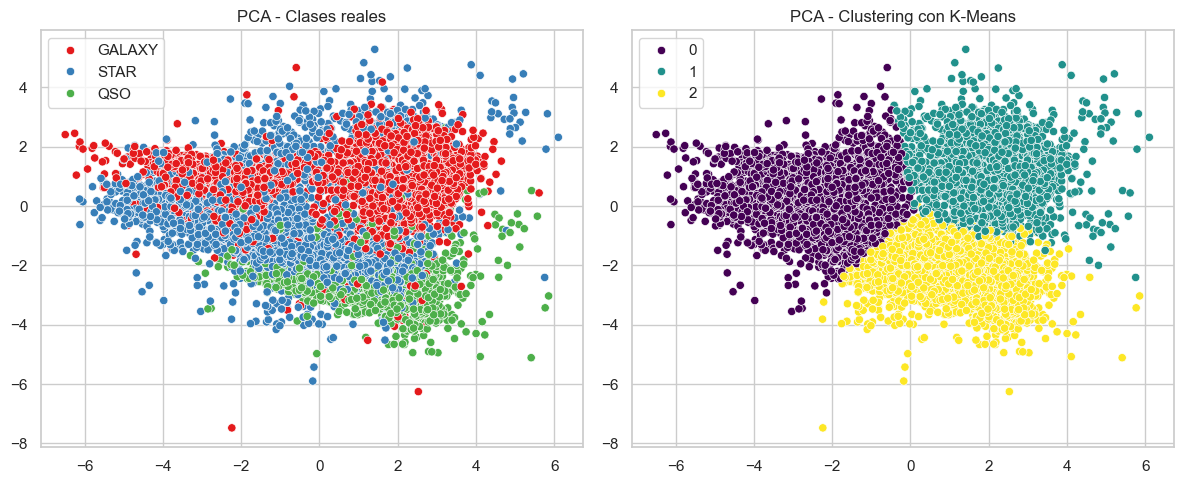

In [88]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=le.inverse_transform(y), palette='Set1')
plt.title("PCA - Clases reales")

plt.subplot(1, 2, 2)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette='viridis')
plt.title("PCA - Clustering con K-Means")

plt.tight_layout()
plt.show()


### Distribución de clases en el dataset

Se grafica la cantidad de ejemplos por clase. 


C:\Users\Suzak\AppData\Local\Temp\ipykernel_7968\3976561053.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['class'], order=df['class'].value_counts().index, palette='Set2')


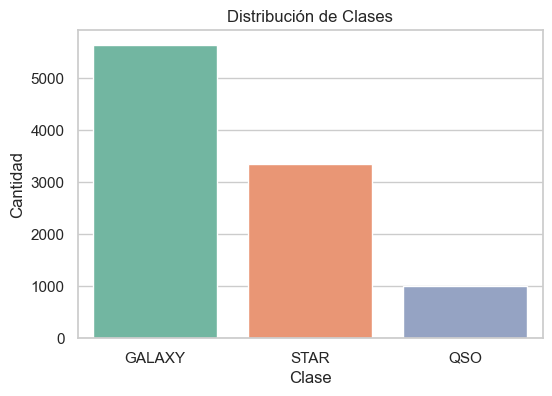

In [89]:
plt.figure(figsize=(6,4))
sns.countplot(x=df['class'], order=df['class'].value_counts().index, palette='Set2')
plt.title("Distribución de Clases")
plt.xlabel("Clase")
plt.ylabel("Cantidad")
plt.show()

### Importancia de características

Se entrena un modelo Random Forest sobre todas las features originales para visualizar cuáles tienen mayor peso en la clasificación. Las más importantes podrían usarse para mejorar futuros modelos.


C:\Users\Suzak\AppData\Local\Temp\ipykernel_7968\3531479089.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=features, palette='Blues_d')


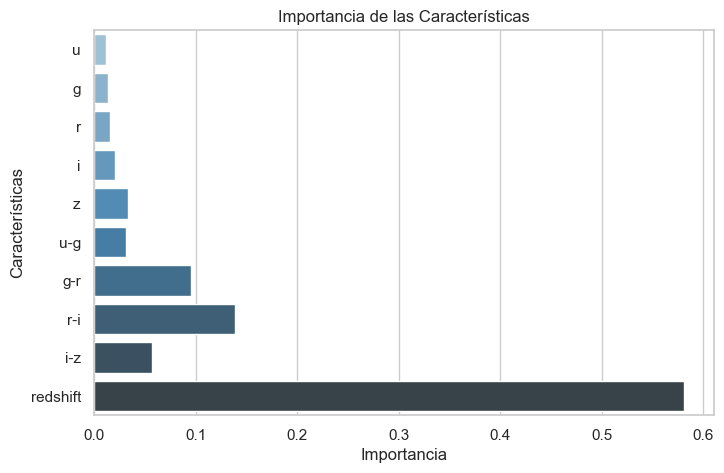

In [90]:
clf_full = RandomForestClassifier(n_estimators=100, random_state=42)
clf_full.fit(X_scaled, y)
importances = clf_full.feature_importances_

plt.figure(figsize=(8,5))
sns.barplot(x=importances, y=features, palette='Blues_d')
plt.title("Importancia de las Características")
plt.xlabel("Importancia")
plt.ylabel("Características")
plt.show()